## Create Feed Forward Neural Network
- 1 input, 1 output, with 1 hidden layer and 2 neurons with some weights, 100 data points

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


def activation_function(x, func): # could add ReLU, Leaky ReLU, or Softmax
    if func == 'sigmoid':
        return(1/(1 + np.exp(-x)))
    elif func == 'tanh':
        return np.tanh(x)


class FFNN_Generator(object):

    def __init__(self, node_layers:list[int]=[]):
        self.node_layers = node_layers
        self.weight_matrix = []
        self.init_weights()
    
    def init_weights(self):
        if len(self.node_layers) > 1:

            for i in range(len(self.node_layers)-1):
                # rows of the weight matrix are the from # of inputs
                rows = self.node_layers[i]
                # columns of the weight matrix are the neurons in the layer
                columns = self.node_layers[i+1]
                weights = np.random.rand(rows, columns)
                self.weight_matrix.append(weights)
    

    def feedforward(self, input):
        I = input # I is input to the next layer
        out = None
        print(self.weight_matrix)
        for i, weight in enumerate(self.weight_matrix):
            I_W = np.dot(I, weight)

            if i == (len(self.weight_matrix) - 1):
                out = activation_function(I_W, 'tanh') # output layer
            else:
                I = activation_function(I_W, 'tanh') # updating inputs for hidden layers
        return out # output matrix shape (1x100)
    
    
    

# instantiate this neural network
# Data_Generator = FFNN_Generator([1, 2, 1])

Data_Generator = FFNN_Generator([1, 1, 1]) # testing with 1 input, 1 neuron, 1 output
 


# input 1, 1 hidden layer (2 neurons therefore 1*2 = 2 weights), 1 output
# hidden layer (2 weights * 100 inputs) -> shape is (2x100)
# output matrix shape (1x100)

## Generate Data From First Network

In [2]:
input = np.random.rand(100, 1)
data = Data_Generator.feedforward(input)
target_weights = Data_Generator.weight_matrix

# convert to tensors
data = torch.tensor(data, dtype = torch.float32)
target_weights = [torch.tensor(weight, dtype = torch.float32) for weight in target_weights]

# concatenate weights into a single tensor as the second NN expects weights to have same shape as output
target_weights = torch.cat([weight.flatten() for weight in target_weights]).unsqueeze(0)

print("Generated Data:", data[:5])
print("Feed Forward Neural Network 1 Weights:", target_weights)


[array([[0.87519693]]), array([[0.61721728]])]
Generated Data: tensor([[0.0121],
        [0.3065],
        [0.0595],
        [0.0778],
        [0.1774]])
Feed Forward Neural Network 1 Weights: tensor([[0.8752, 0.6172]])


## Create Second Neural Network
- use data created by first neural network to train this second RNN 
- use adam optimizer to investigate weight decay
- 2 scenarios: firstly, leave at default, no regularization, second, give some value that is supposed to help training (maybe look at adam and weight decay parameter documentaiton)

In [3]:
class FFNN_Predictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN_Predictor, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size, bias = False) # remove bias
        self.tanh = nn.Tanh()
        self.ho = nn.Linear(hidden_size, output_size, bias = False) # remove bias
    
    def forward(self, x):
        out = self.fc(x)
        out = self.tanh(out)
        out = self.ho(out)

        return out

# instantiate second networks
# predictor1 = FFNN_Predictor(input_size = data.shape[1], hidden_size = 2, output_size = 1)
# predictor2 = FFNN_Predictor(input_size = data.shape[1], hidden_size = 2, output_size = 1)

predictor1 = FFNN_Predictor(input_size = data.shape[1], hidden_size = 1, output_size = 1) # test 1 neuron
predictor2 = FFNN_Predictor(input_size = data.shape[1], hidden_size = 1, output_size = 1) # test 1 neuron

# loss arrays for plotting
loss_no_decay = []
loss_decay = []


## Testing the Weight Decay with Two Training Sets

In [4]:
# loss function
learning_rate = 0.01
criterion = nn.MSELoss() 
optimizer = optim.Adam(predictor1.parameters(), lr=learning_rate) # FFNN_parameters provides the parameters (weight and biases) to be updated as training progresses

# could try 1 and 2 neurons

# train model
epochs = 1000

for epoch in range(epochs):
    optimizer.zero_grad()

    # predict weights of generated data neural network
    predicted_weights = predictor1(data)

    # compute loss
    loss1 = criterion(predicted_weights, target_weights)
    loss1.backward()

    # update weights of this second neural network
    optimizer.step()

    loss_no_decay.append(loss1.item())
    print(f"Epoch {epoch}/{epochs}, Loss: {loss1.item()}")

# after training, grab the weights predicted by the second neural netowrk
predicted_weights1 = {name: param.data.numpy() for name, param in predictor1.named_parameters()}




c:\Users\tjawo\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 2])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0/1000, Loss: 0.7626168727874756
Epoch 1/1000, Loss: 0.7570278644561768
Epoch 2/1000, Loss: 0.7515370845794678
Epoch 3/1000, Loss: 0.7461452484130859
Epoch 4/1000, Loss: 0.7408530712127686
Epoch 5/1000, Loss: 0.7356611490249634
Epoch 6/1000, Loss: 0.7305700778961182
Epoch 7/1000, Loss: 0.7255802750587463
Epoch 8/1000, Loss: 0.720691978931427
Epoch 9/1000, Loss: 0.7159053683280945
Epoch 10/1000, Loss: 0.7112206220626831
Epoch 11/1000, Loss: 0.706637442111969
Epoch 12/1000, Loss: 0.7021558880805969
Epoch 13/1000, Loss: 0.697775661945343
Epoch 14/1000, Loss: 0.6934963464736938
Epoch 15/1000, Loss: 0.6893173456192017
Epoch 16/1000, Loss: 0.6852381825447083
Epoch 17/1000, Loss: 0.6812581419944763
Epoch 18/1000, Loss: 0.6773765087127686
Epoch 19/1000, Loss: 0.673592209815979
Epoch 20/1000, Loss: 0.6699044108390808
Epoch 21/1000, Loss: 0.6663120985031128
Epoch 22/1000, Loss: 0.6628139615058899
Epoch 23/1000, Loss: 0.6594090461730957
Epoch 24/1000, Loss: 0.6560958027839661
Epoch 25/1000,

In [5]:
# loss function
learning_rate = 0.01
criterion = nn.MSELoss() 
optimizer = optim.Adam(predictor2.parameters(), lr=learning_rate, weight_decay=0.01) # FFNN_parameters provides the parameters (weight and biases) to be updated as training progresses

# 1 layer, 2-3 neurons for weight decay, all other neurons should be close to zero

# train model
epochs = 10000

for epoch in range(epochs):
    optimizer.zero_grad()

    # predict weights of generated data neural network
    predicted_weights = predictor2(data)

    # compute loss
    loss2 = criterion(predicted_weights, target_weights)
    loss2.backward()

    # update weights of this second neural network
    optimizer.step()

    loss_decay.append(loss2.item())
    print(f"Epoch {epoch}/{epochs}, Loss: {loss2.item()}")

# after training, grab the weights predicted by the second neural netowrk
predicted_weights2 = {name: param.data.numpy() for name, param in predictor2.named_parameters()}


Epoch 0/10000, Loss: 0.6833831667900085
Epoch 1/10000, Loss: 0.6790624856948853
Epoch 2/10000, Loss: 0.6748256087303162
Epoch 3/10000, Loss: 0.6706735491752625
Epoch 4/10000, Loss: 0.666606605052948
Epoch 5/10000, Loss: 0.6626255512237549
Epoch 6/10000, Loss: 0.6587308645248413
Epoch 7/10000, Loss: 0.6549226641654968
Epoch 8/10000, Loss: 0.6512013077735901
Epoch 9/10000, Loss: 0.6475669145584106
Epoch 10/10000, Loss: 0.6440193057060242
Epoch 11/10000, Loss: 0.6405584216117859
Epoch 12/10000, Loss: 0.6371840238571167
Epoch 13/10000, Loss: 0.6338955760002136
Epoch 14/10000, Loss: 0.6306926608085632
Epoch 15/10000, Loss: 0.6275746822357178
Epoch 16/10000, Loss: 0.6245406866073608
Epoch 17/10000, Loss: 0.6215900182723999
Epoch 18/10000, Loss: 0.6187214851379395
Epoch 19/10000, Loss: 0.6159340143203735
Epoch 20/10000, Loss: 0.6132264137268066
Epoch 21/10000, Loss: 0.6105972528457642
Epoch 22/10000, Loss: 0.6080450415611267
Epoch 23/10000, Loss: 0.6055684089660645
Epoch 24/10000, Loss: 0.603

In [6]:
print("Actual Weights:", target_weights)
print("No Decay Estimated Weights:", predicted_weights1)
print("Decay 0.01 Estimated Weights:", predicted_weights2)

Actual Weights: tensor([[0.8752, 0.6172]])
No Decay Estimated Weights: {'fc.weight': array([[-2.1940782]], dtype=float32), 'ho.weight': array([[-1.4385836]], dtype=float32)}
Decay 0.01 Estimated Weights: {'fc.weight': array([[-2.1176248]], dtype=float32), 'ho.weight': array([[-1.4318497]], dtype=float32)}


## Compare Loss Differences

In [7]:
import matplotlib.pyplot as plt

loss_differences = []

for l1, l2 in zip(loss_no_decay, loss_decay):
    avg_loss = (l1 + l2) / 2
    percent_diff = ((l1 - l2) / avg_loss) * 100
    loss_differences.append(percent_diff)

for epoch, diff in enumerate(loss_differences, 1):
    print(f"Epoch {epoch}/{epochs}, Percent Difference: {percent_diff:.2f}%")

Epoch 1/10000, Percent Difference: -0.98%
Epoch 2/10000, Percent Difference: -0.98%
Epoch 3/10000, Percent Difference: -0.98%
Epoch 4/10000, Percent Difference: -0.98%
Epoch 5/10000, Percent Difference: -0.98%
Epoch 6/10000, Percent Difference: -0.98%
Epoch 7/10000, Percent Difference: -0.98%
Epoch 8/10000, Percent Difference: -0.98%
Epoch 9/10000, Percent Difference: -0.98%
Epoch 10/10000, Percent Difference: -0.98%
Epoch 11/10000, Percent Difference: -0.98%
Epoch 12/10000, Percent Difference: -0.98%
Epoch 13/10000, Percent Difference: -0.98%
Epoch 14/10000, Percent Difference: -0.98%
Epoch 15/10000, Percent Difference: -0.98%
Epoch 16/10000, Percent Difference: -0.98%
Epoch 17/10000, Percent Difference: -0.98%
Epoch 18/10000, Percent Difference: -0.98%
Epoch 19/10000, Percent Difference: -0.98%
Epoch 20/10000, Percent Difference: -0.98%
Epoch 21/10000, Percent Difference: -0.98%
Epoch 22/10000, Percent Difference: -0.98%
Epoch 23/10000, Percent Difference: -0.98%
Epoch 24/10000, Perc

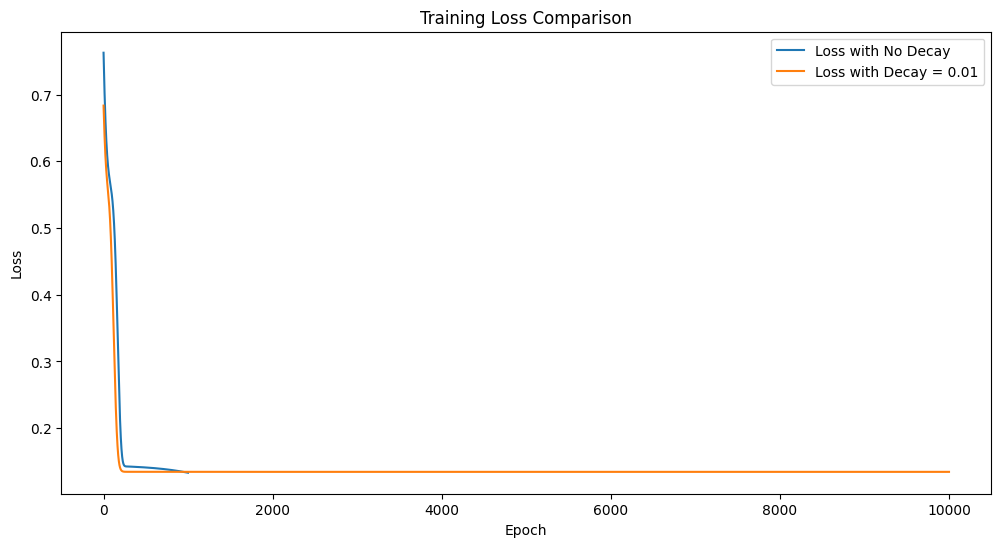

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(loss_no_decay, label = 'Loss with No Decay')
plt.plot(loss_decay, label = 'Loss with Decay = 0.01')
plt.title('Training Loss Comparison')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# ppl give vague guidlines about constructing neural netowrks
# another small problem once you construct nn want to use model somewhere
# for multiapplications, you have target output and want to find suitable input, reverse optimization

# from there having dynamic model and make code for mpc, target y and decide input